### Momentos Gerais

Definimos _Momento de Imagem_ como a **média ponderada das intensidades dos pixels de uma imagem**. Considerando uma imagem $I(x,y)$ quadrada de dimensão $NxN$, podemos calcular os seus momentos na forma:

$$M_{pq} = \sum_{x=0}^{N-1}\sum_{y=0}^{N-1}x^py^qI(x, y)$$

A expressão acima mostra o somatório de todas os valores de pixel $I(x,y)$ ponderados pela posição $x$ e $y$ a potências $p$ e $q$. Em outras palavras, momentos são valores que carregam informação espacial completa (localização e intesidade), ou seja, informação de forma. Os valores $p$ e $q$ são chamados de ordem das dimensões $X$ e $Y$, respectivamente. A ordem do momento em si é dado por $p+q$.

### Cálculo do Centróide

Podemos extrair informações valiosas de $M_{pq}$. É fácil ver que $M_{00}$ é um acumulador de valores de intensidade (i.e número de pixels diferentes de zero), e a partir disso é possível calcular as coordenadas do centróide da massa de pixels $(\bar{x}, \bar{y})$:

$$\bar{x} = \frac{M_{10}}{M_{00}}$$
$$\bar{y} = \frac{M_{01}}{M_{00}}$$

### Invariância à Translação

O centróide, por sua vez, pode ser usado para modificar $M_{pq}$ para chegar a uma expressão **invariante a translação** $\mu_{pq}$:

$$\mu_{pq} = \sum_{x=0}^{N-1}\sum_{y=0}^{N-1}(x - \bar{x})^p(y - \bar{y})^qI(x, y)$$

Aqui, a informação de localização dos pixels é levada em conta com relação ao referencial do centróide. Isso quer dizer que, independente de onde a massa de pixels esteja localizada, $\mu_{pq}$ não muda.

### Invariância à Escala

Outra transformação comum em imagens é o escalamento, ou mudança de tamanho. Esse escalamento pode ser uniforme (igual em todas as direções) ou não-uniforme. A partir de relações algébricas, podemos chegar a uma expressão $\eta_{pq}$ de momentos **invariantes à escala**:

$$\eta_{pq} = \frac{\mu_{pq}}{\mu_{00}^{1 + \frac{p+q}{2}}}$$

A formulação acima é invariante tanto ao escalamento uniforme quanto ao não-uniforme. Como $\eta_{pq}$ é calculado com os momentos invariantes à translação $\mu_{pq}$, é fácil ver que eles são invariantes a ambas as transformações.

### Momentos de Hu: Invariância Completa

Com o desafio de criar um conjunto completo de valores invariantes às transformações afins de translação, escala e rotação, (Hu, 1962) introduziu 7 valores batizados de Momentos de Hu:

$h_1 = \eta_{20} + \eta_{02}$

$h_2 = (\eta_{20} - \eta_{02})^2 + 4(\eta_{11})^2$

$h_3 = (\eta_{30} - 3\eta_{12})^2 + 3(\eta_{03} - 3\eta_{21})^2$

$h_4 = (\eta_{30} + \eta_{12})^2 + (\eta_{03} + \eta_{21})^2$

$h_5 = (\eta_{30} - 3\eta_{12})(\eta_{30} + \eta_{12})[(\eta_{30} + \eta_{12})^2 - 3(\eta_{03} + \eta_{21})^2] + (3\eta_{21} - \eta_{03})(\eta_{03} + \eta_{21})[3(\eta_{30} + \eta_{12})^2 - (\eta_{03} + \eta_{21})^2]$

$h_6 = (\eta_{20} - \eta_{02})[(\eta_{30} + \eta_{12})^2 - 7(\eta_{03} + \eta_{21})^2] + 4\eta_{11}(\eta_{30} + \eta_{12})(\eta_{03} + \eta_{21})$

$h_7 = (3\eta_{21} - \eta_{03})(\eta_{30} + \eta_{12})[(\eta_{30} + \eta_{12})^2 - 3(\eta_{03} + \eta_{21})^2] + (\eta_{30} - 3\eta_{12})(\eta_{03} + \eta_{21})[3(\eta_{30} + \eta_{12})^2 - (\eta_{03} + \eta_{21})^2]$

### Aplicação Prática: Classficação de Formas Simples

O uso dos Momentos de Hu será ilustrado com um problema de classificação de forma simples. Um conjunto de dados com 14970 amostras de quatro classes (círculo, quadrado, estrela e triângulo) foi escolhido. O conjunto é livre e pode ser obtido no [Kaggle](https://www.kaggle.com/smeschke/four-shapes). As animações abaixo mostram as 400 primeiras amostras de cada classe afim de ilustrar a diversidade de exemplos.

| ![SegmentLocal](images/circles.gif "segment") | ![SegmentLocal](images/squares.gif "segment") | ![SegmentLocal](images/stars.gif "segment") | ![SegmentLocal](images/triangles.gif "segment") |
|-----------------------------------------------|-----------------------------------------------|-----------------------------------------------|-----------------------------------------------|

Usaremos Python, OpenCV e scikit-learn nessa demonstração. Primeiro, vamos importar as bibliotecas necessárias.

In [1]:
import os
import sys
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC as SVM
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.neighbors import NearestCentroid as DMC
from sklearn.model_selection import train_test_split as data_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

Em seguida, vamos definir dois diciónarios (i.e relação de variáveis). O primeiro representa a relação entre o nome literal das classes. O segundo, o conjunto de classificadores que experimentaremos. São eles:

- **DMC:** Distância Mínima ao Centróide
- **LDA:** Discriminante Limiar
- **QDA:** Discriminante Quadrático
- **SMV_linear:** Support Vector Machine com kernel linear
- **SMV_radial:** Support Vector Machine com kernel radial

In [2]:
classes = {
	"circle"   : 1,
	"square"   : 2,
	"star"     : 3,
	"triangle" : 4
}

classifiers = {
	"DMC" : DMC(),
	"LDA" : LDA(),
	"QDA" : QDA(),
	"SVM_linear" : SVM(kernel="linear"),
	"SVM_radial" : SVM(kernel="rbf")
}

A primeira função definida faz a extração dos Momentos de Hu de cada uma das classes, gerando um arquivo .csv com os atributos extraídos mais as informações de classe e número de amostra. Os valores originais não são salvos. Em vez disso, uma transformação logarítmica é aplicada aos momentos. O motivo está na grande diferença na ordens dos momentos, o que, do ponto de vista de classificação, não é uma boa prática.

In [29]:
def feature_extraction(data_file, segmentate=False):
	dump = []
	
	print("Extracting Hu moments...")
	
	for c, idx in classes.items():
		class_folder = "data/{}/".format(c)
		
		for f in os.listdir(class_folder):
			fpath = class_folder + f
			sample = int(f.replace(".png", ""))
			
			img = cv2.imread(fpath, cv2.IMREAD_GRAYSCALE)
			
			if segmentate:
				img = cv2.bilateralFilter(img, 11, 17, 17)
				img = cv2.Canny(img, 30, 200)
				img = cv2.bitwise_not(img)
			
			hu = cv2.HuMoments(cv2.moments(img))
			
			for i in range(0, 7):
				hu[i] = -1 * np.sign(hu[i]) * np.log10(np.abs(hu[i]))
			
			hu = hu.reshape((1, 7)).tolist()[0] + [sample, idx]
			dump.append(hu)
		
		print(c, "ok!")

	cols = ["hu1", "hu2", "hu3", "hu4", "hu5", "hu6", "hu7", "sample", "class"]
	
	df = pd.DataFrame(dump, columns=cols)
	df.to_csv(data_file, index=None)
	df.head(20)
	
	print("Extraction done!")

Executando essa função e salvando o resultado no arquivo ```hu_moments.csv```, temos:

In [12]:
data_file = "hu_moments.csv"

feature_extraction(data_file)

Extracting Hu moments...
circle ok!
square ok!
star ok!
triangle ok!
        hu1        hu2        hu3        hu4        hu5        hu6        hu7  \
0  2.976302  10.862073  16.236278  14.197972  29.472187  20.236255 -29.733116   
1  2.953107  10.391985  15.132586  12.833541  28.315505  18.341507 -26.816823   
2  2.931488  11.913204  15.282587  14.760891 -29.790725 -21.270751 -30.500958   
3  2.946141  10.519378  15.406552  14.050944 -28.827426 -19.329421 -29.132084   
4  2.989636  11.580799  16.247847  14.115397  29.352122  20.331075  29.621781   

   sample  class  
0    3245      1  
1    2929      1  
2    1749      1  
3    3112      1  
4     545      1  
Extraction done!


A seguir, vamos definir a função que executa os classificadores. O conjunto de dados extraídos foram separados em subconjuntos de treinamento e teste na proporção 70/30 ao longo de 100 interações. O resultados de acurácia de todas as interação é salvo numa variável para análise:

In [27]:
def classification(data_file, rounds=100, remove_disperse=False):
	df = pd.read_csv(data_file)
	df = df.drop(["sample"], axis=1)
	
	if remove_disperse:
		df = df.drop(["hu5", "hu6", "hu7"], axis=1)
	
	X = df.drop(["class"], axis=1)
	y = df["class"]
	
	ans = {key: {"score" : [], "sens" : [], "spec" : []}
	       for key, value in classifiers.items()}
	
	print("Classifying...")
	
	for i in range(rounds):
		X_train, X_test, y_train, y_test = data_split(X, y, test_size=0.3)
		
		for name, classifier in classifiers.items():
			scaler = StandardScaler()
			scaler.fit(X_train)
			X_train = scaler.transform(X_train)
			X_test = scaler.transform(X_test)
			
			classifier.fit(X_train, y_train)
			score = classifier.score(X_test, y_test)
			
			ans[name]["score"].append(score)
		
	print("Classification done!")
	
	return ans

Executando a função no conjunto de atributos recém-extraídos, temos:

In [14]:
ans = classification(data_file)

Classifying...
Classification done!


A variável ```ans``` guarda os resultados de classificação de todas as iterações. Para facilitar a análise, vamos escrever uma função que cácula média, mediana, valor máximo, valor mínimo e desvio padrão de todos os resultados de acurácia e formata o resultado em de maneira mais legível.

In [16]:
def sumary(ans, title="Vizualizando resposta de classificacao"):
	size = 70
	separator = "-"
	
	print(separator*size)
	print("SUMARY: {}".format(title))
	print(separator*size)
	print("CLASSIF\t\tMEAN\tMEDIAN\tMINV\tMAXV\tSTD")
	print(separator*size)
	
	for n in ans:
		m = round(np.mean(ans[n]["score"])*100, 2)
		med = round(np.median(ans[n]["score"])*100, 2)
		minv = round(np.min(ans[n]["score"])*100, 2)
		maxv = round(np.max(ans[n]["score"])*100, 2)
		std = round(np.std(ans[n]["score"])*100, 2)
		
		print("{:<16}{}\t{}\t{}\t{}\t{}".format(n, m, med, minv, maxv, std))
	
	print(separator*size)
	print()

Executando ```sumary()```, temos:

In [18]:
sumary(ans)

----------------------------------------------------------------------
SUMARY: Vizualizando resposta de classificacao
----------------------------------------------------------------------
CLASSIF		MEAN	MEDIAN	MINV	MAXV	STD
----------------------------------------------------------------------
DMC             90.72	90.73	89.45	91.89	0.51
LDA             96.03	96.04	95.48	96.53	0.24
QDA             95.72	95.7	95.23	96.26	0.23
SVM_linear      96.48	96.48	96.04	97.11	0.22
SVM_radial      97.29	97.31	96.66	97.8	0.2
----------------------------------------------------------------------



### Conclusão Preliminar

Com taxas de classificação médias acima dos 90% em todos os classificadores protótipo, uma taxa máxima de 97,29% usando SVM e baixas taxas de desvio padrão, podemos concluir que os Momentos de Hu foram capazes de extrair uma boa descritibilidade dos objetos em questão.

A seguir, vamos analisar, com base nas natureza dos Momentos de Hu, os valores de cada um dos atributos afim de encontrar uma configuração que possa trazer uma melhor classificação.

### Filtrando o Vetor de Atributos

Vamos escrever uma função que nos mostra a dispersão dos valores de cada um dos 7 valores do vetor de atributos. Visualmente, gráficos de caixa são ótimos para essa tarefa.

In [23]:
def data_exploration(data_file):
	df = pd.read_csv(data_file)
	fig, ax = plt.subplots(2, 2, sharey=True, figsize=(16,8))
	ax = ax.reshape((1, 4))[0]
	
	for c, idx in classes.items():
		data = df.loc[df["class"] == idx].drop(["sample", "class"], axis=1)
		
		ax[idx-1].set_title(c)
		data.boxplot(ax=ax[idx-1])
	
	plt.suptitle("Dispersão dos momentos por classe")
	plt.tight_layout()
	plt.show()

Executando para o arquivo de momentos já extraídos, temos:

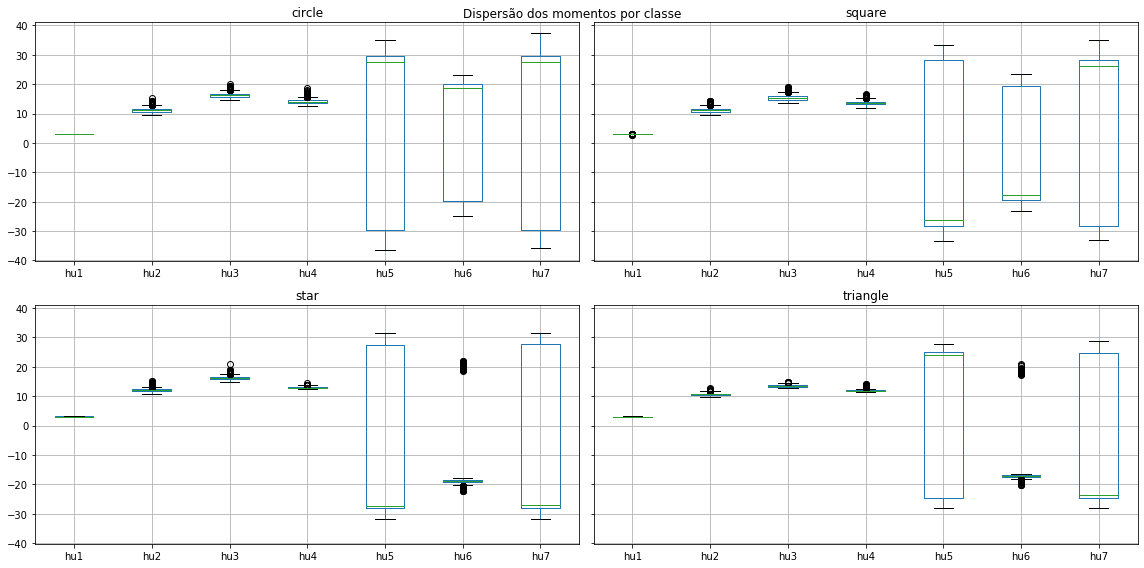

In [24]:
data_exploration(data_file)

Os primeiros 4 Momentos de Hu apresentam um mesmo comportamento de estabilidade e agrupamento. Entretanto, os momentos de 5 a 7 apresentam uma grande variabidade. Mesmo no caso do $hu6$ nas classes ```star``` e ```triangle```, podemos interpretar o aglomerado de outliers superiores distantes do grupo da mediana como do mesmo tamanho das caixas presentes em ```circle``` e ```square```.

Essa análise é uma pista para a remoção desses valores do vetor de atributos. Vamos executar a classificação novamente, agora removendo $(hu5, hu6, hu7)$:

In [28]:
ans2 = classification(data_file, remove_disperse=True)
sumary(ans2)

Classifying...
Classification done!
----------------------------------------------------------------------
SUMARY: Vizualizando resposta de classificacao
----------------------------------------------------------------------
CLASSIF		MEAN	MEDIAN	MINV	MAXV	STD
----------------------------------------------------------------------
DMC             92.14	92.12	90.92	92.99	0.4
LDA             96.04	96.09	95.41	96.75	0.25
QDA             95.74	95.72	95.15	96.55	0.27
SVM_linear      96.42	96.43	95.93	96.88	0.23
SVM_radial      97.5	97.49	97.08	97.88	0.18
----------------------------------------------------------------------



Podemos ver que o classificador Distância Mínima ao Centróide foi favorecido com a essa remoção de valores do vetor de atributos. Já que esse preditor trabalha com o centróide da massa de atributos, valores dispersos movem o centróide de forma que possa gerar confusão entre as classes.